In [1]:
import numpy as np
import torch
from mcspace.model import MCSPACE
from mcspace.trainer import train_model
from mcspace.data_utils import get_data, get_mouse_diet_perturbations_dataset
from mcspace.utils import get_device, pickle_load, pickle_save,\
    estimate_process_variance, MODEL_FILE, DATA_FILE, \
    get_mcspace_cooccur_prob, get_sig_perturbation_diff_subset, \
    get_posterior_summary_data, get_pert_otu_sub, get_min_loss_path, apply_taxonomy_threshold, \
    get_summary_results
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import mcspace.visualization as vis
from mcspace.dataset import DataSet
import pandas as pd

import ete3
from Bio import SeqIO, Phylo

import mcspace.vis_tools as vis
import matplotlib.colors as mcolors
import networkx as nx

In [2]:
# change font
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

# Paths

In [3]:
rootpath = Path("../../")
basepath = Path("./")

In [4]:
runpath = rootpath / "paper" / "mouse_runs" / "runs"

In [5]:
treepath = rootpath / "data" / "mouse_experiments" / "output" # *** rename this
treefile = "newick_tree_query_reads.nhx"

In [6]:
outpath = basepath / "figs_mouse_results"
outpath.mkdir(exist_ok=True, parents=True)

# Load best model

In [7]:
respath = get_min_loss_path(runpath, np.arange(10))

model = torch.load(respath / MODEL_FILE)
data = pickle_load(respath / DATA_FILE)

taxonomy = pickle_load(respath / "taxonomy.pkl")

times = list(data['count_data'].keys())
subjects = list(data['count_data'][10].keys())
num_otus = data['count_data'][times[0]][subjects[0]].shape[1]
num_times = len(times)
num_subjects = len(subjects)

0
1
2
3
4
5
6
7
8
9
4


In [8]:
taxonomy = apply_taxonomy_threshold(taxonomy)

# do beforehand..
name_updates = {'Otu10': {'Species': 'Faecalibaculum rodentium'},
'Otu17': {'Genus': 'Roseburia'},
'Otu6': {'Species': 'Eubacterium coprostanoligenes'},
'Otu20': {'Species': 'Muribaculum gordoncarteri'},
'Otu15': {'Genus': 'Eisenbergiella'},
'Otu43': {'Family': 'Lachnospiraceae'}}

taxonomy['Species'] = 'na'
for oidx in name_updates.keys():
    replace = name_updates[oidx]
    key = list(replace.keys())[0]
    newname = replace[key]
    taxonomy.loc[oidx,key] = newname

# Get summary results

In [9]:
thetadf, betadf, pertsdf = get_posterior_summary_data(model, data, taxonomy, times, subjects)

# Make figure

### to do: final criteria for what to include

In [10]:
# dict of diets and times
diet_times = {'STD': [10,35,57,76],
'HF': [18],
'HFHF': [43],
'LP': [65]}

In [11]:
def average_diet_times(df, diet_times):
    df2 = df.copy()
    diets_keep = list(diet_times.keys())
    for k in diets_keep:
        df2[k] = df.loc[:,diet_times[k]].mean(axis=1)
    df2 = df2[diets_keep]
    return df2

# TO do: get colormap from data fig...

In [12]:
# def get key focus taxa...
# taxa_foci = ['Otu2', 'Otu6']
taxa_foci = ['Otu15', 'Otu12', 'Otu8', 'Otu1', 'Otu21', 'Otu2', 'Otu6', 'Otu3']
otu_threshold = 0.01

colors = np.concatenate([sns.color_palette('muted', n_colors=10), sns.color_palette("dark", n_colors=10)])
familycolors = {x:y for x,y in zip(taxonomy['Family'].unique(),colors)}

avebeta = vis.get_subj_averaged_assemblage_proportions(betadf)
radf = vis.get_relative_abundances(data, times, subjects, taxonomy)

edge_weights = {}
node_weights = {}
pcolors = {}
for otuf in taxa_foci:
    assemblages = vis.get_assemblages_containing_taxon(thetadf, otuf)
    otus = vis.get_taxa_in_assemblages(thetadf, assemblages)
    
    edge_weights_temp = vis.get_edge_weights(thetadf, avebeta, assemblages, otuf, otus)
    ratemp = radf.loc[edge_weights_temp.index,:]
    node_weights[otuf] = average_diet_times(ratemp, diet_times)
    edge_weights[otuf] = average_diet_times(edge_weights_temp, diet_times)
    
    ncolors = {}
    for oidx in edge_weights_temp.index:
        fam = taxonomy.loc[oidx,'Family']
#         print(oidx, fam)
        ncolors[oidx] = familycolors[fam]
    pcolors[otuf] = ncolors

In [13]:
edge_threshold = 0.01
print(edge_weights['Otu2'].index[(edge_weights['Otu2']>edge_threshold).any(axis=1)])

Index(['Otu67', 'Otu1', 'Otu7', 'Otu17', 'Otu41', 'Otu38', 'Otu20', 'Otu10',
       'Otu2', 'Otu29', 'Otu6'],
      dtype='object', name='Otu')


In [14]:
def plot_association_changes(axs, edge_weights, node_weights, otu_focus, taxonomy,
                             node_colors=None, edge_scale=20, node_scale=2000, rad=1, textsize=12,
                            edge_threshold=0.02, edge_base=0):
    
    # subset over taxa that exceed edge_threshold on some diet
    
#     taxa = edge_weights.index
    taxa = edge_weights.index[(edge_weights>edge_threshold).any(axis=1)]
#     print(edge_weights)
#     print(taxa)
    diets = edge_weights.columns

    # make graph
    graph = nx.Graph()
    # add nodes and edges with default weights
    for oidx in taxa:
        if oidx != otu_focus:
            graph.add_edge(oidx, otu_focus, weight=1)
        graph.nodes[oidx]['weight'] = 500

    # get node positions
    pos = nx.spring_layout(graph)

    notus = len(taxa)
    xpos =  np.cos(np.linspace(0,1,notus)*2*np.pi)
    ypos =  np.sin(np.linspace(0,1,notus)*2*np.pi)
    i = 0
    for oidx in taxa:
        if oidx != otu_focus:
            pos[oidx] = np.array([xpos[i],ypos[i]])
            i += 1
        else:
            pos[oidx] = np.array([0,0])

    for i,diet in enumerate(diets):
        # update edge weights
        for oidx in taxa:
            if oidx != otu_focus:
                if edge_weights.loc[oidx,diet] >= edge_threshold:
                    graph[oidx][otu_focus]['weight'] = edge_scale*edge_weights.loc[oidx,diet] + edge_base
                else:
                    graph[oidx][otu_focus]['weight'] = 0
            # update node sizes
            graph.nodes[oidx]['weight']=node_scale*node_weights.loc[oidx,diet]

        # get node colors
        color_map = []
        for node in graph:
            if node_colors is not None:
                color_map.append(node_colors[node])
            else:
                color_map.append('tab:blue')

        # draw network
        ew = list(nx.get_edge_attributes(graph,'weight').values())
        nw = list(nx.get_node_attributes(graph,'weight').values())
        nx.draw_networkx(graph, pos=pos, ax=axs[i], width=ew, node_size=nw, 
                         node_color=color_map, with_labels=False, alpha=0.2)
        

        # annotate nodes
        for k in pos.keys():
            x = pos[k][0]
            y = pos[k][1]
            style = 'normal'
            if i == 0:
                s, level = vis.get_lowest_level(k, taxonomy)
                if (level == 'Genus') or (level == 'Species'):
                    style = 'italic'
                if level == 'Species':
                    genus, species = s.split(' ')
                    s = f'{genus[0]}. {species}'
                if k == otu_focus:
#                     s = taxonomy.loc[k,'Genus']
                    axs[i].text(x, y + 0.15 ,s=s, horizontalalignment='center', verticalalignment='center', fontsize=textsize, fontstyle=style)
                else:
#                     s = taxonomy.loc[k,'Genus'] # use lowest level instead...; italicize below family
                    # center those closest to zero...
                    if np.abs(x) < 0.2:
                        axs[i].text(x, 1.15*y + np.sign(y)*0.1 ,s=s, horizontalalignment='center', verticalalignment='center', 
                                    fontsize=textsize, fontstyle=style)
                    elif x > 0:
                        axs[i].text(x+0.1, 1.15*y ,s=s, horizontalalignment='left', verticalalignment='center', 
                                    fontsize=textsize, fontstyle=style)
                    else:
                        axs[i].text(x-0.1, 1.15*y ,s=s, horizontalalignment='right', verticalalignment='center', 
                                    fontsize=textsize, fontstyle=style)

            s = f'{k}'
            s = s[(s.find('u')+1):]
            axs[i].text(x, y ,s=s, horizontalalignment='center', verticalalignment='center', fontsize=textsize)
                    
                    
    return axs, graph

In [15]:
def plot_association_changes2(axs, edge_weights, node_weights, otu_focus, taxonomy,
                             node_colors=None, edge_scale=20, node_scale=2000, rad=1, textsize=12,
                            edge_threshold=0.02, edge_base=0, alpha=0.2):
    
    # subset over taxa that exceed edge_threshold on some diet
    
#     taxa = edge_weights.index
    taxa = edge_weights.index[(edge_weights>edge_threshold).any(axis=1)]
#     print(edge_weights)
#     print(taxa)
    diets = edge_weights.columns

    # make graph
    graph = nx.Graph()
    # add nodes and edges with default weights
    for oidx in taxa:
        if oidx != otu_focus:
            graph.add_edge(oidx, otu_focus, weight=1)
    for oidx in taxa:
        graph.nodes[oidx]['weight'] = 500

    # get node positions
    pos = nx.spring_layout(graph)

    notus = len(taxa)
    xpos =  np.cos(np.linspace(0,1,notus)*2*np.pi)
    ypos =  np.sin(np.linspace(0,1,notus)*2*np.pi)
    i = 0
    for oidx in taxa:
        if oidx != otu_focus:
            pos[oidx] = np.array([xpos[i],ypos[i]])
            i += 1
        else:
            pos[oidx] = np.array([0,0])

    for i,diet in enumerate(diets):
        # update edge weights
        for oidx in taxa:
            if oidx != otu_focus:
                if edge_weights.loc[oidx,diet] >= edge_threshold:
                    graph[oidx][otu_focus]['weight'] = edge_scale*edge_weights.loc[oidx,diet] + edge_base
                else:
                    graph[oidx][otu_focus]['weight'] = 0
            # update node sizes
            graph.nodes[oidx]['weight']=node_scale*node_weights.loc[oidx,diet]

        # get node colors
        color_map = []
        for node in graph:
            if node_colors is not None:
                color_map.append(node_colors[node])
            else:
                color_map.append('tab:blue')

        # draw network
        ew = list(nx.get_edge_attributes(graph,'weight').values())
        nw = list(nx.get_node_attributes(graph,'weight').values())
        nx.draw_networkx(graph, pos=pos, ax=axs[i], width=ew, node_size=nw, 
                         node_color=color_map, with_labels=False, alpha=alpha)
        

        # annotate nodes
        for k in pos.keys():
            x = pos[k][0]
            y = pos[k][1]
            style = 'normal'
#             if i == 0:

            s, level = vis.get_lowest_level(k, taxonomy)
            if (level == 'Genus') or (level == 'Species'):
                style = 'italic'
            if level == 'Species':
                genus, species = s.split(' ')
                s = f'{genus[0]}. {species}'

            if k == otu_focus:
                yp = y + 0.2
            else:
                if np.abs(y)<0.3:
                    yp = y
                else:
                    if x > 0:
                        yp = y-0.1
                    else:
                        yp = y+0.1
                
                
            axs[i].text(x, yp ,s=s, horizontalalignment='center', verticalalignment='center', 
                        fontsize=textsize, fontstyle=style)

                    
    return axs, graph

In [16]:
len(taxa_foci)

8

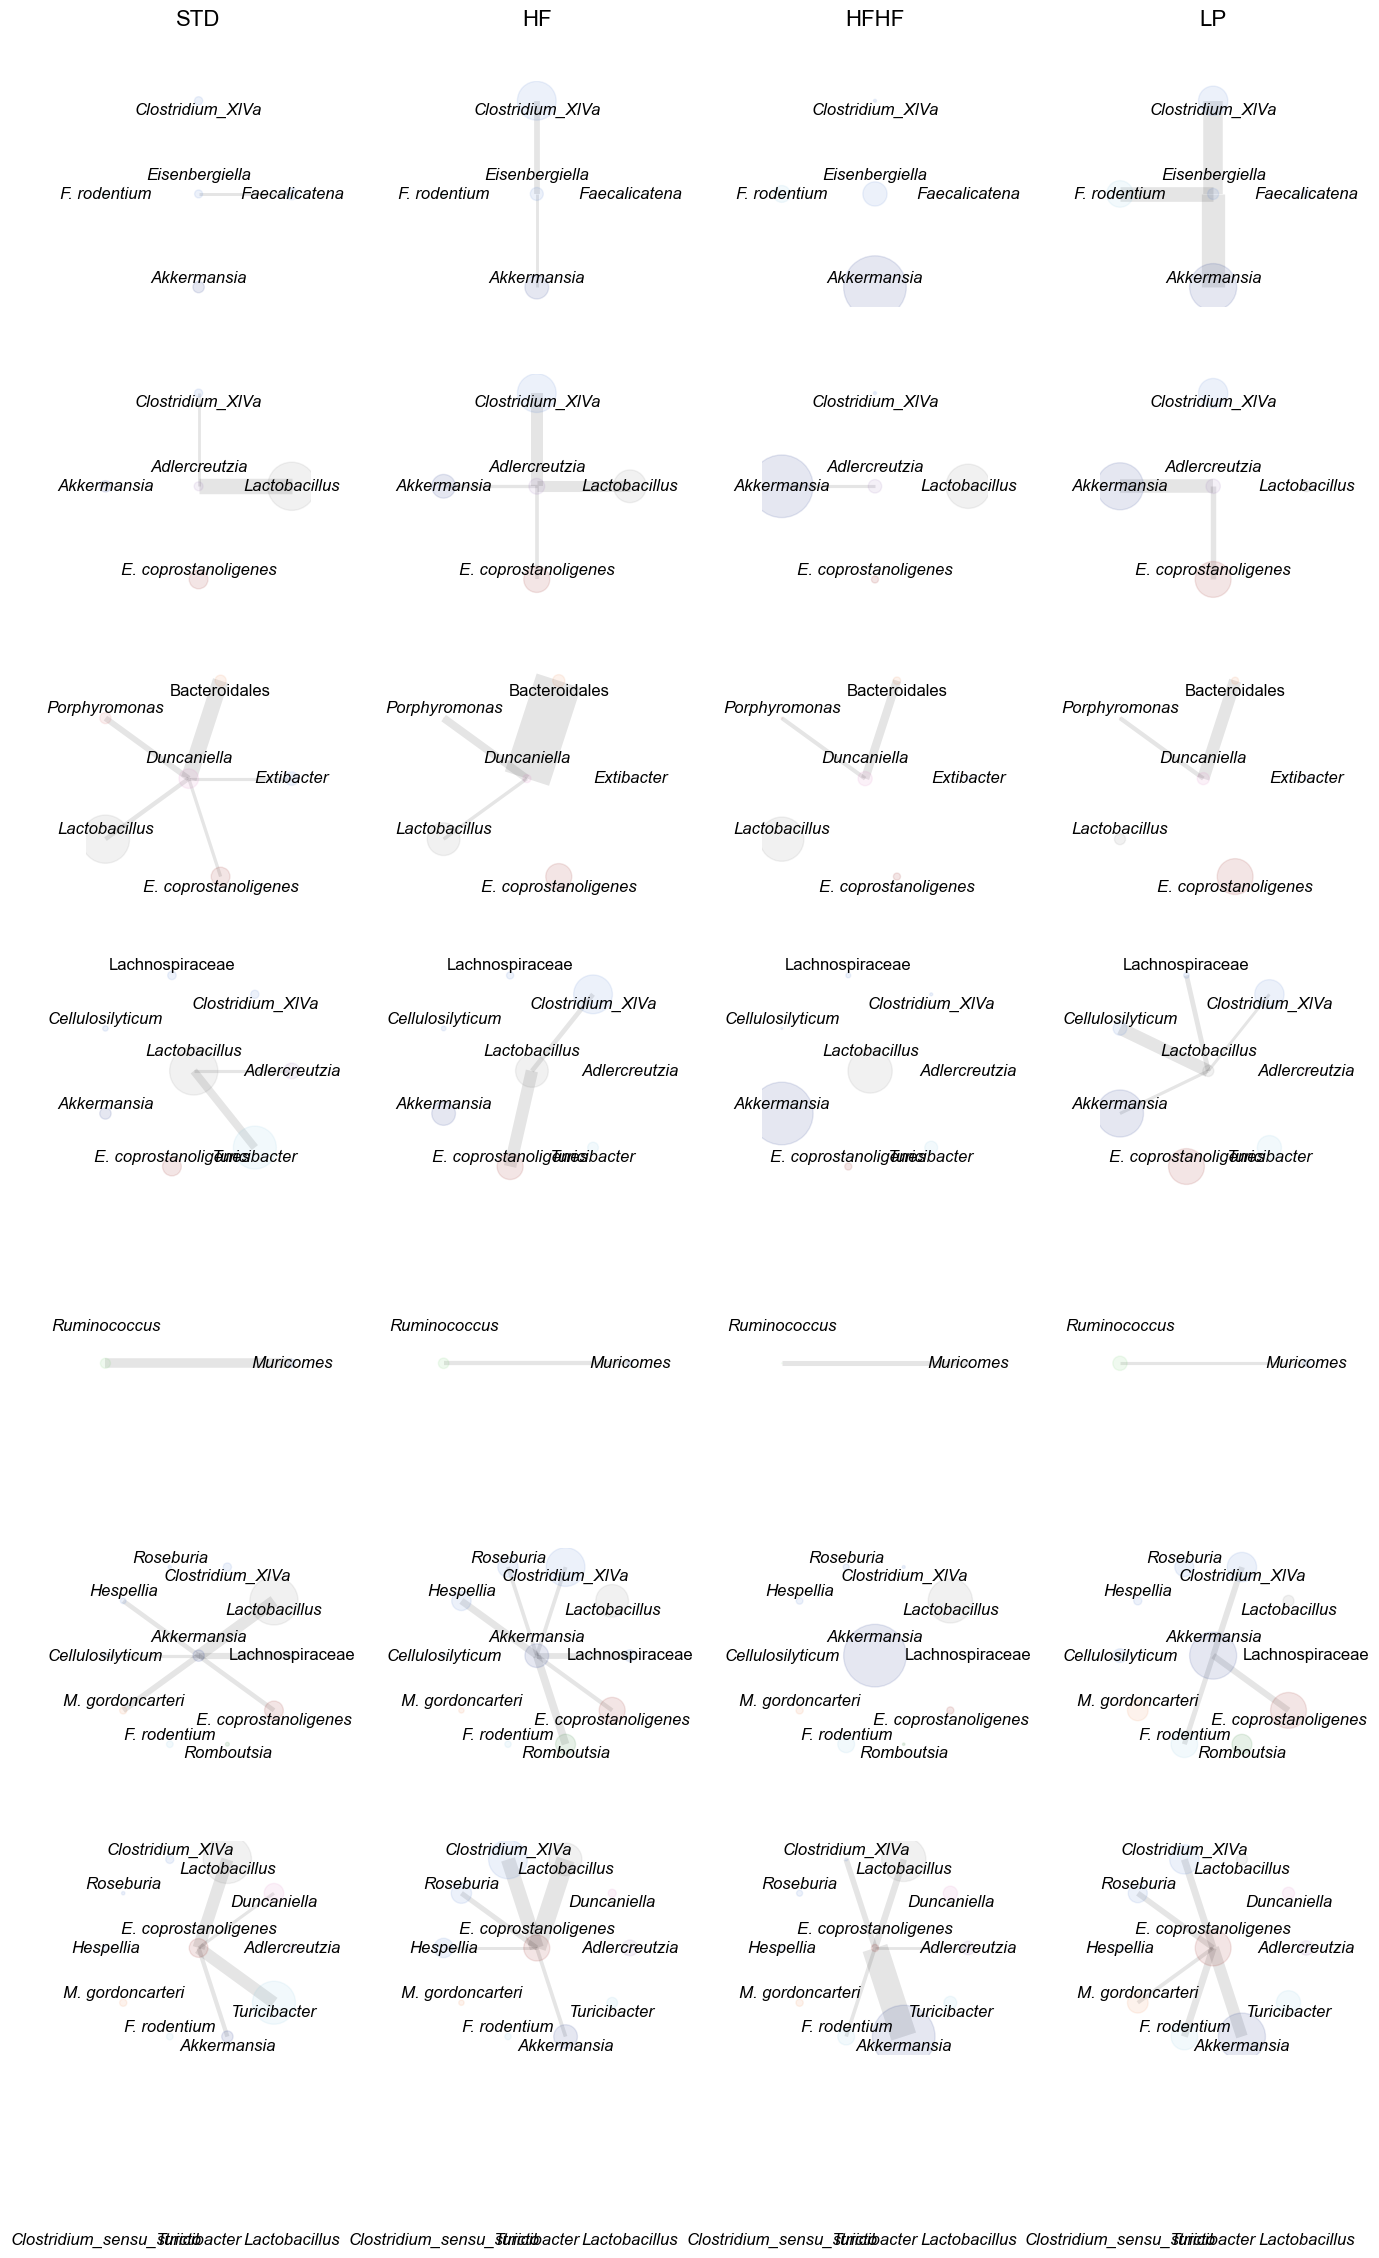

In [17]:
fig, axs = plt.subplots(figsize=(16,32), ncols=4, nrows=len(taxa_foci))

for row_idx in range(len(taxa_foci)):
    otuf = taxa_foci[row_idx]
    _,_=plot_association_changes2(axs[row_idx,:], edge_weights[otuf], node_weights[otuf], otuf, taxonomy, 
                                        node_colors=pcolors[otuf], edge_scale=200, node_scale=5000, rad=1.2,
                                       edge_threshold = 0.01, edge_base=0, textsize=12, alpha=0.1)
    diets = edge_weights[otuf].columns
    for ax, diet in zip(axs[row_idx,:], diets):
        ax.set_aspect('equal', 'box')
        ax=vis.remove_border(ax)
        
        if row_idx == 0:
            ax.set_title(diet, pad=40, fontsize=16)

plt.subplots_adjust(wspace=0.5, hspace=-0.3)
    
plt.savefig(outpath / "association_changes.pdf", bbox_inches="tight")
plt.savefig(outpath / "association_changes.png", bbox_inches="tight")

### for assymetry issue - first make sure normalziastion is correct; then check, maybe not plot when abundance below a treshold, since values won't make sense; or if using theta threshold in calculating edge weights, that might help too
### could also drop all nodes below ra threshold at any point??

# figure out legend

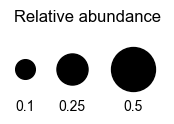

In [18]:
fig, ax = plt.subplots(figsize=(2,1))
ab = [0.1, 0.25, 0.5]
xp = np.array([-0.08, -0.02, 0.06])
for x,s in zip(xp,ab):
    ax.scatter(x,0,s=s*2000, c='black')
    ax.text(x,-0.05, s=f'{s}', verticalalignment='center', horizontalalignment='center')
ax.set_ylim(-0.05,0.05)
ax.set_xlim(-0.1,0.1)
ax.set_aspect('equal', 'box')
ax.set_title("Relative abundance")
ax=vis.remove_border(ax)

# save and manually add with illustrator

### line thickness... (PLOT A FEW VALUES of thickness as with r.a.)

## color map for family... -- try to keep consistent with fig 2 (though now alpha is higher)

In [19]:
node_weights['Otu2']

,STD,HF,HFHF,LP
Otu,,,,
Otu15,0.006535,0.017412,0.060776,0.012782
Otu12,0.008222,0.025964,0.018783,0.021430
Otu67,0.002308,0.014471,0.001184,0.001008
Otu1,0.240700,0.110752,0.202902,0.012623
Otu7,0.006949,0.155743,0.000924,0.089202
Otu17,0.001178,0.042695,0.003755,0.037520
Otu41,0.003254,0.039001,0.004629,0.006763
Otu38,0.003037,0.002256,0.000416,0.019459
Otu20,0.005345,0.002962,0.005396,0.044075


# to do :
- legend components: colormap, edge width, circle size, ...tax naming?
- clean up further -> only include taxa that have an edge on some diet

### is there a directionality?; is it weird that akkermansia associates on hfhf in bottom but not top???; because of normalization...; think about this though...

## if picking less than 4 taxa; can transpose figure to increase sizes and area (have diets going down)

# to do:
- figure out normalization and asymmetry - what makes sense for measure (marginal prob)?
- get criteria for what 'focus' taxa to include (top N changing?); those with x amount of change?; those with x abundance in each diet...

### check what taxa we'd get with each criteria; pick a final one

In [20]:
radf

,10,18,35,43,57,65,76
Otu,,,,,,,
Otu19,8.851155e-03,5.468554e-04,0.003100,7.071050e-04,0.007016,7.629251e-03,0.039296
Otu37,6.800378e-07,3.631561e-03,0.000052,2.039855e-05,0.009004,4.492318e-03,0.029349
Otu24,1.674976e-03,3.465165e-04,0.010295,2.248963e-03,0.017545,2.000217e-03,0.045857
Otu15,3.286075e-03,1.741164e-02,0.002091,6.077623e-02,0.004819,1.278174e-02,0.015945
Otu22,4.171356e-02,1.523307e-02,0.006992,5.668465e-03,0.001008,5.059938e-03,0.001827
...,...,...,...,...,...,...,...
Otu52,2.371512e-03,8.827805e-07,0.006756,1.932187e-04,0.007076,4.882975e-04,0.012342
Otu39,3.509433e-03,1.358767e-07,0.009781,7.410701e-08,0.020641,5.243872e-05,0.017881
Otu98,1.258324e-03,6.309004e-03,0.002462,2.057613e-03,0.001374,2.357072e-03,0.005351


In [21]:
diet_times

{'STD': [10, 35, 57, 76], 'HF': [18], 'HFHF': [43], 'LP': [65]}

In [22]:
avera = average_diet_times(radf,diet_times)

In [23]:
avera

,STD,HF,HFHF,LP
Otu,,,,
Otu19,0.014566,5.468554e-04,7.071050e-04,7.629251e-03
Otu37,0.009601,3.631561e-03,2.039855e-05,4.492318e-03
Otu24,0.018843,3.465165e-04,2.248963e-03,2.000217e-03
Otu15,0.006535,1.741164e-02,6.077623e-02,1.278174e-02
Otu22,0.012885,1.523307e-02,5.668465e-03,5.059938e-03
...,...,...,...,...
Otu52,0.007136,8.827805e-07,1.932187e-04,4.882975e-04
Otu39,0.012953,1.358767e-07,7.410701e-08,5.243872e-05
Otu98,0.002611,6.309004e-03,2.057613e-03,2.357072e-03


## check taxa above threshold for at least 3 time points

#### should contain at least otus 2 and 6; otu 1 may or may not be of interest in general...

In [24]:
rathres = 0.02
tsub = avera.index[(avera>rathres).sum(axis=1)>=3]
print(tsub)
rathres2 = 0.01
print((avera.loc[tsub,:]>rathres2).sum(axis=1))

Index(['Otu1', 'Otu2', 'Otu6'], dtype='object', name='Otu')
Otu
Otu1    4
Otu2    4
Otu6    3
dtype: int64


In [25]:
rathres = 0.01
print(avera.index[(avera>rathres).sum(axis=1)>=3])

Index(['Otu15', 'Otu12', 'Otu8', 'Otu1', 'Otu21', 'Otu2', 'Otu6', 'Otu3'], dtype='object', name='Otu')


### add 'extra' criteria if using ra of 0.01...

In [26]:
taxonomy.loc['Otu3']

Domain                Bacteria
Phylum              Firmicutes
Class         Erysipelotrichia
Order       Erysipelotrichales
Family     Erysipelotrichaceae
Genus             Turicibacter
Species                     na
Name: Otu3, dtype: object

In [27]:
edge_weights['Otu3']>0.01

Time,STD,HF,HFHF,LP
Otu,,,,
Otu13,False,False,False,False
Otu1,True,True,True,False
Otu48,False,True,False,False
Otu6,False,False,False,False
Otu3,True,True,True,True


In [28]:
taxonomy.loc['Otu48']

Domain                      Bacteria
Phylum                    Firmicutes
Class                     Clostridia
Order                  Clostridiales
Family              Clostridiaceae_1
Genus      Clostridium_sensu_stricto
Species                           na
Name: Otu48, dtype: object

# taxa that yagmur's focusing on